In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import numpy as np
import time
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
scaler = preprocessing.MinMaxScaler()
LIM=10
PATH = "./../out/uniprot_sprot.90.multi-step/"

In [16]:
def time_ms():
    return round(time.time()*1000)

def clean_column_ids(df, col):
    return df[col].map(lambda x: x.split("|")[1])

def parse_fasta(protein_fasta):
    id = protein_fasta.split("\n")[0]
    sequence = ''.join(protein_fasta.split("\n")[1:])
    return (id, sequence)



In [17]:
def read_score(path):
    df = pd.read_csv(path,   delimiter=r"\s+", comment="#", usecols=[0,2,4,5,6,10,11], header=None)
    df.columns = ["sequence", "reference", "eval", "score", "bias", "exp_dom", "n_dom"]
    df.sort_values(by=["score"], inplace=True, ascending=False)
    df["sequence"] = clean_column_ids(df, "sequence")
    df.set_index("sequence", inplace=True)
    return df
def read_identity(path, ref):
    df = pd.read_csv(path,   delimiter=r"\s+", comment="#", usecols=[0,1,2,3,4], header=None)
    df.columns = ["seq1", "seq2", "identity", "nid", "denom"]
    idx1 = df["seq1"].str.contains(ref)
    idx2 = df["seq2"].str.contains(ref)
    df = df[idx1 | idx2]
    idx = (df["seq2"].str.contains(ref))
    # put all references to the seq2 column
    df.loc[idx, ["seq1", "seq2"]] = df.loc[idx, ["seq2", "seq1"]].values
    df["seq2"] = df["seq2"].map(lambda x: x.split("|")[1])
    return df.drop(columns=["seq1"]).set_index("seq2")
def read_family(path):
    df = None
    try:
        df = pd.read_csv(path, delimiter=r"\s+", comment="#", usecols=[0,2,4,5,6], header=None)
    except pd.errors.EmptyDataError:
        return pd.DataFrame(columns=["family", "seq", "f_eval", "f_score", "f_bias"])
    df.columns = ["family", "seq", "f_eval", "f_score", "f_bias"]
    df["seq"] = clean_column_ids(df, "seq")
    #df.drop_duplicates(subset=["seq"], keep="first", inplace=True)
    df.set_index("seq", inplace=True)
    return df
def read_len(path):
    db_fasta = ""
    with open(path, "r") as f:
        db_fasta = ("\n" + f.read()).split("\n>")[1:]
    a = []
    for protein_fasta in db_fasta:
        id, seq = parse_fasta(protein_fasta)
        id = id.split("|")[1]
        a.append((id, seq, len(seq)))
    return pd.DataFrame(a, columns=["seq", "str", "seqlen"]).set_index("seq").rename_axis(index=None)
    

In [18]:
def load_all(path, normalise=True, lim=LIM):
    id_files = sorted(glob.glob(path.replace("$$$", "id")))
    hmms_files = sorted(glob.glob(path.replace("$$$", "hmmsearch")))
    phmm_files = sorted(glob.glob(path.replace("$$$", "phmmer")))
    fam_files = sorted(glob.glob(path.replace("$$$", "hmmscan")))
    fasta_files = sorted(glob.glob(path.replace("$$$", "clean").replace(".out", ".clean.fasta")))
    dfs = []
    files = list(zip(hmms_files, phmm_files, id_files, fam_files, fasta_files))
    for file in files[:lim]:
        ref = file[0].split("/")[-1].split(".")[0]
        hmms_df = read_score(file[0]).rename(columns={"score" : "hmms_score", "eval" : "hmms_eval", "bias" : "hmms_bias", "exp_dom": "hmms_exp_dom", "n_dom": "hmms_n_dom"})
        phmm_df = read_score(file[1]).rename(columns={"score" : "phmm_score", "eval" : "phmm_eval", "bias" : "phmm_bias", "exp_dom": "phmm_exp_dom", "n_dom": "phmm_n_dom"})
        phmm_df.drop(["reference"], axis=1, inplace=True)
        id_df = read_identity(file[2], ref)
        fam_df = read_family(file[3])
        len_df = read_len(file[4])
        df = pd.concat([phmm_df, hmms_df, id_df, len_df], axis=1)
        df = df.join(fam_df)
        if normalise:
            df["phmm_score"] = scaler.fit_transform(df["phmm_score"].values.reshape(-1,1))
            df["hmms_score"] = scaler.fit_transform(df["hmms_score"].values.reshape(-1,1))
        dfs.append(df)
    frame = pd.concat(dfs, axis=0)
    return frame


In [20]:
data = load_all(PATH + "$$$/*.out", lim=20, normalise=False)

ValueError: No objects to concatenate

In [ ]:
def splot(df, x, y, hue=None, legend=True, ylog=False):
    f, ax = plt.subplots(figsize=(6.5,6.5))
    sb.set_theme(style="whitegrid")
    if ylog:
        ax.set(yscale="log")
    sb.scatterplot(x=x, y=y, hue=hue, ax=ax, data=df)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    if ax.get_legend() and not legend:
        ax.get_legend().remove()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


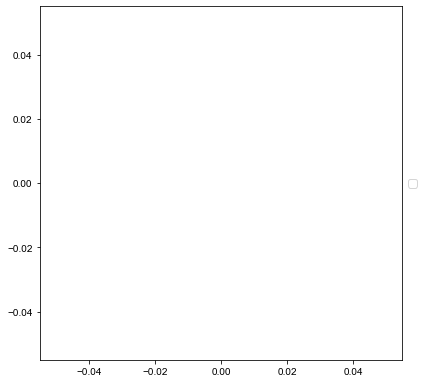

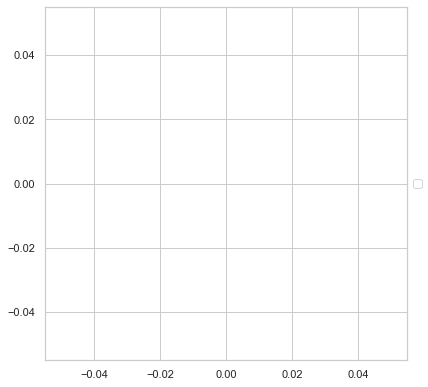

In [ ]:
temp = data.reset_index().drop_duplicates(subset="index", keep="first").set_index("index")
splot(temp, "identity", "phmm_score", hue="family")
splot(temp, "identity", "phmm_score", hue="reference")

- Phmmer vs. identity relationship quite linear
- One color represents one PFAM domain/cluster
- Usually, one cluster has one PFAM domain


No handles with labels found to put in legend.


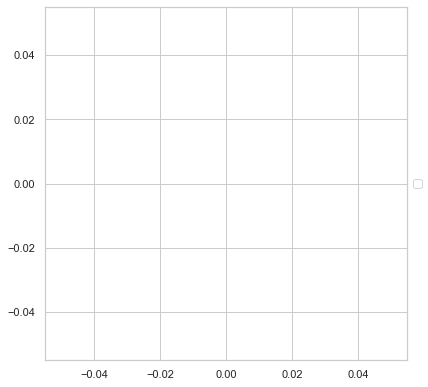

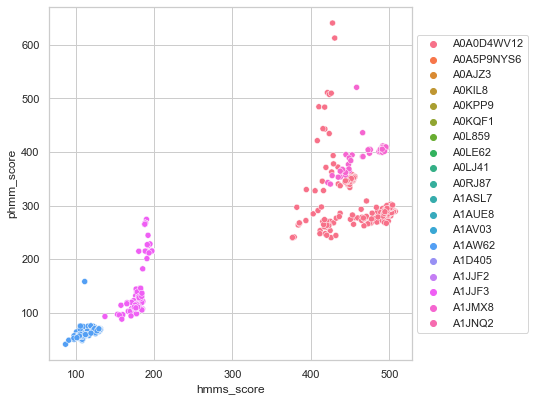

In [ ]:
splot(temp, "hmms_score", "phmm_score", hue="family")
splot(temp, "hmms_score", "phmm_score", hue="reference")

- Relationship between phmmer (cluster vs. reference) and hmmsearch (cluster vs. MSA) score
- 10 different clusters, one color represents one PFAM domain/cluster
- Most clusters have a linear relationship between these two variables
- No apparent behavioral similarity between two different clusters

In [ ]:
data.corr(method="pearson").style.background_gradient(cmap="coolwarm").set_precision(2)


,phmm_eval,phmm_score,phmm_bias,phmm_exp_dom,phmm_n_dom,hmms_eval,hmms_score,hmms_bias,hmms_exp_dom,hmms_n_dom,identity,nid,denom,seqlen,f_eval,f_score,f_bias
phmm_eval,1.00,-0.04,-0.01,-0.00,-0.00,1.00,-0.05,-0.02,-0.02,nan,nan,nan,nan,-0.02,0.05,0.01,-0.03
phmm_score,-0.04,1.00,0.60,-0.04,0.04,-0.05,0.89,-0.35,-0.41,nan,nan,nan,nan,-0.02,-0.01,0.02,-0.04
phmm_bias,-0.01,0.60,1.00,-0.03,-0.01,-0.03,0.53,0.04,-0.14,nan,nan,nan,nan,-0.04,0.03,-0.00,0.01
phmm_exp_dom,-0.00,-0.04,-0.03,1.00,0.44,0.03,-0.25,0.29,0.83,nan,nan,nan,nan,nan,0.03,-0.01,0.01
phmm_n_dom,-0.00,0.04,-0.01,0.44,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
hmms_eval,1.00,-0.05,-0.03,0.03,nan,1.00,-0.03,0.03,-0.00,-0.00,-0.69,-0.74,-0.19,0.00,0.01,-0.05,0.03
hmms_score,-0.05,0.89,0.53,-0.25,nan,-0.03,1.00,0.17,-0.12,-0.00,0.75,0.71,-0.31,-0.11,-0.17,0.41,-0.44
hmms_bias,-0.02,-0.35,0.04,0.29,nan,0.03,0.17,1.00,0.24,-0.01,0.22,0.20,-0.11,0.07,0.21,-0.39,0.57
hmms_exp_dom,-0.02,-0.41,-0.14,0.83,nan,-0.00,-0.12,0.24,1.00,0.08,nan,nan,nan,nan,0.06,-0.12,0.21
hmms_n_dom,nan,nan,nan,nan,nan,-0.00,-0.00,-0.01,0.08,1.00,nan,nan,nan,nan,nan,nan,nan


- Correlation matrix
- Linear correlation between all variables
- nid: number of identical aligned pairs
- denom: denominator used for the calculation: the shorter of the two (unaligned) sequence lengths.
- f_score: family score
- f_eval: family e-value

In [ ]:
data.corr(method="spearman").style.background_gradient(cmap="coolwarm").set_precision(2)

,phmm_eval,phmm_score,phmm_bias,phmm_exp_dom,phmm_n_dom,hmms_eval,hmms_score,hmms_bias,hmms_exp_dom,hmms_n_dom,identity,nid,denom,seqlen,f_eval,f_score,f_bias
phmm_eval,1.00,-1.00,-0.75,0.20,-0.05,0.91,-0.90,0.25,0.45,nan,nan,nan,nan,0.06,-0.00,-0.00,0.10
phmm_score,-1.00,1.00,0.75,-0.20,0.05,-0.91,0.91,-0.25,-0.45,nan,nan,nan,nan,-0.06,0.00,0.00,-0.10
phmm_bias,-0.75,0.75,1.00,0.00,0.02,-0.61,0.62,0.41,0.00,nan,nan,nan,nan,-0.24,0.02,-0.02,0.04
phmm_exp_dom,0.20,-0.20,0.00,1.00,0.21,0.45,-0.45,0.58,0.99,nan,nan,nan,nan,nan,0.01,-0.01,-0.00
phmm_n_dom,-0.05,0.05,0.02,0.21,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
hmms_eval,0.91,-0.91,-0.61,0.45,nan,1.00,-1.00,0.15,0.25,-0.00,-0.43,-0.40,0.37,0.28,0.36,-0.35,0.53
hmms_score,-0.90,0.91,0.62,-0.45,nan,-1.00,1.00,-0.15,-0.25,0.00,0.43,0.40,-0.37,-0.28,-0.36,0.35,-0.53
hmms_bias,0.25,-0.25,0.41,0.58,nan,0.15,-0.15,1.00,0.26,-0.01,0.07,0.04,-0.04,-0.12,0.43,-0.42,0.67
hmms_exp_dom,0.45,-0.45,0.00,0.99,nan,0.25,-0.25,0.26,1.00,0.05,nan,nan,nan,nan,0.16,-0.15,0.25
hmms_n_dom,nan,nan,nan,nan,nan,-0.00,0.00,-0.01,0.05,1.00,nan,nan,nan,nan,nan,nan,nan


- Monotonic correlation
- nid: number of identical aligned pairs
- denom: denominator used for the calculation: the shorter of the two (unaligned) sequence lengths.
- f_score: family score
- f_eval: family e-value

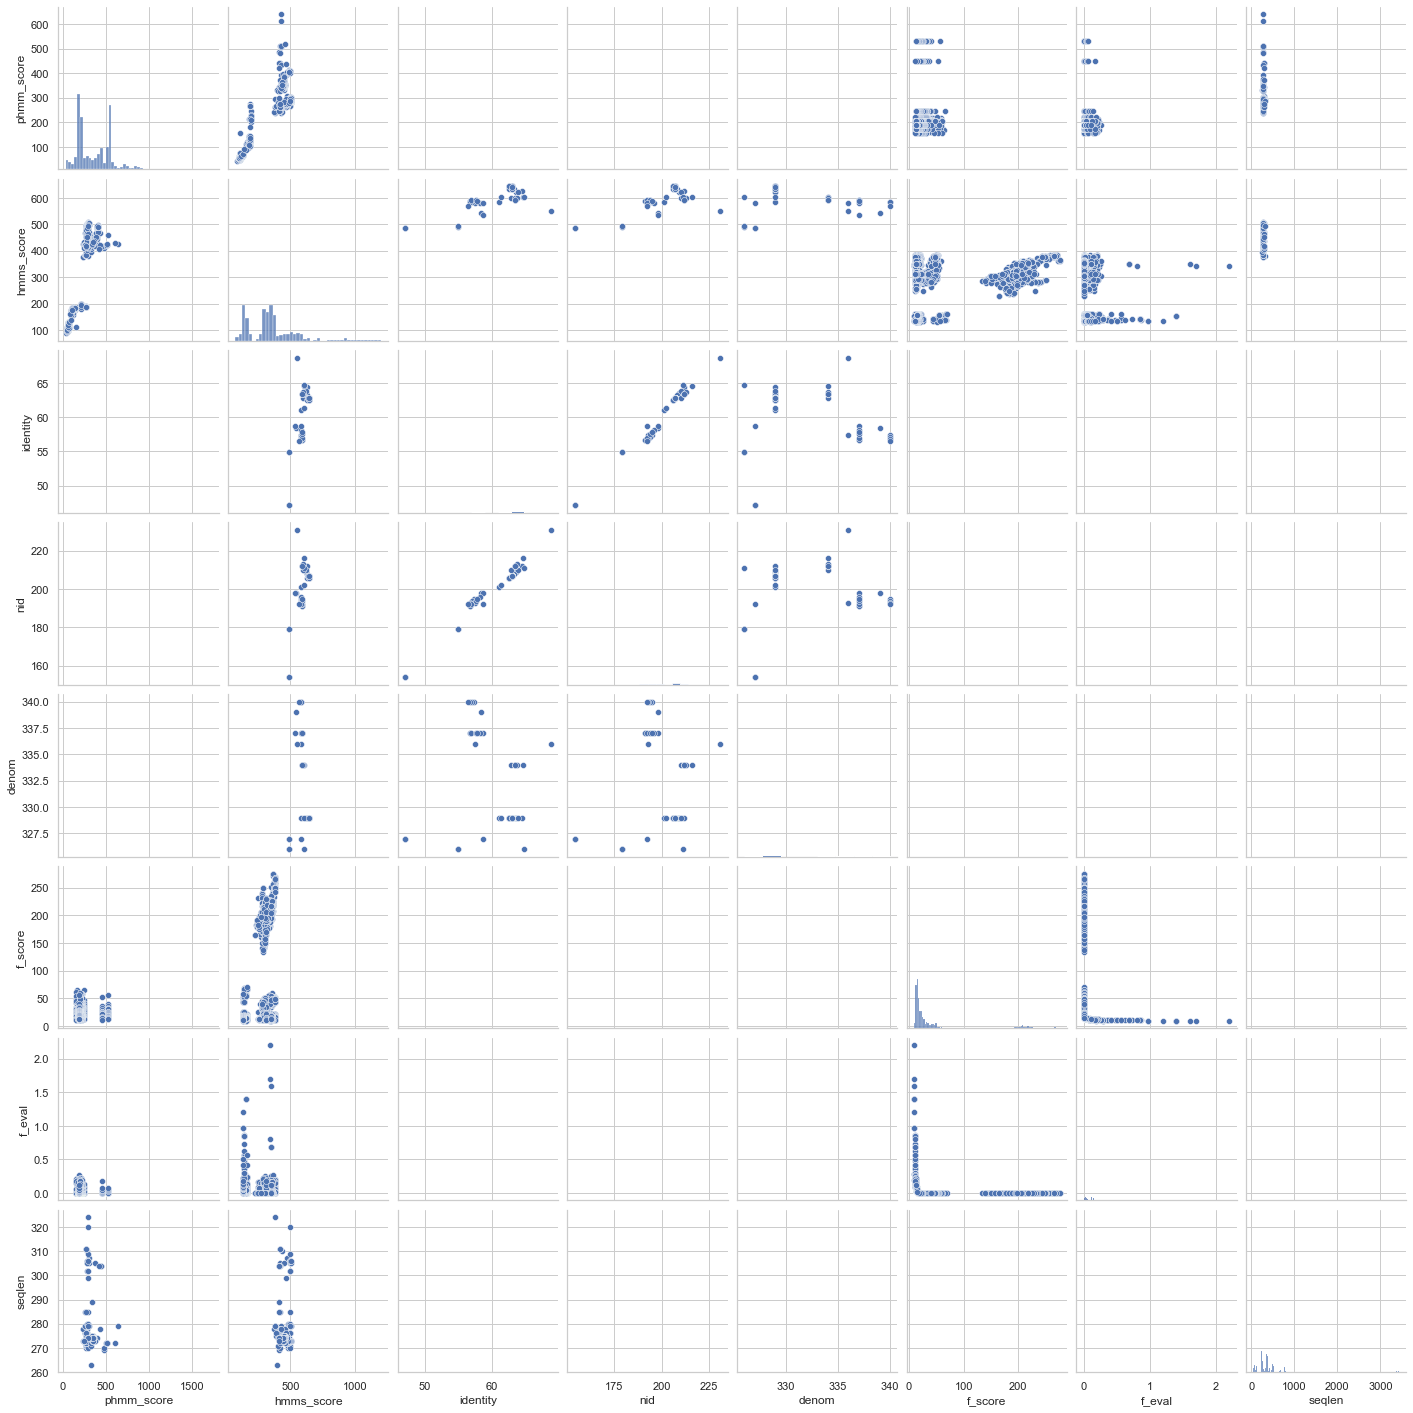

In [ ]:
sb.pairplot(data[["phmm_score", "hmms_score", "identity", "nid", "denom", "f_score", "f_eval", "seqlen"]])

In [ ]:
def ith_fam(df, i, use_none=False):
    m = {}
    for seq in df.groupby("seq"):
        if use_none and len(seq[1]["family"]) <= i:
            m[seq[0]] = "none"
        else:
            m[seq[0]] = seq[1]["family"].iloc[min(i, len(seq[1]["family"])-1)]
    return m

def get_id(id_map, i, j):
    if i == j:
        return 100
    return id_map[i + j] if i + j in id_map.keys() else id_map[j + i]

def set_map(m, r):
    m[r["seq1"] + r["seq2"]] = r["identity"]

def get_id_map(df):
    m = {}
    df.apply(lambda row: set_map(m, row), axis=1)
    return m


def cluster_matrix(path, fam_i1, fam_i2):
    ids = pd.read_csv(path.replace("$$$", "id"),   delimiter=r"\s+", comment="#", usecols=[0,1,2,3,4], header=None)
    ids.columns = ["seq1", "seq2", "identity", "nid", "denom"]
    ids["seq1"] = clean_column_ids(ids, "seq1")
    ids["seq2"] = clean_column_ids(ids, "seq2")
    id_map = get_id_map(ids)
    fams = pd.read_csv(path.replace("$$$", "hmmscan"), delimiter=r"\s+", comment="#", usecols=[0,2,4,5], header=None)
    fams.columns = ["family", "seq", "eval", "score"]
    fams["seq"] = clean_column_ids(fams, "seq")
    fd1 = ith_fam(fams, fam_i1, True)
    fd2 = ith_fam(fams, fam_i2, True)
    seqs = np.unique(pd.unique(ids["seq1"]).tolist() + pd.unique(ids["seq2"]).tolist()).tolist()
    row_idx = pd.MultiIndex.from_tuples([(k, v) for k, v in fd1.items()], names=["seq", "family1"])
    col_idx = pd.MultiIndex.from_tuples([(k, v) for k, v in fd2.items()], names=["seq", "family2"])
    temp = [[get_id(id_map, x, y) for x in seqs] for y in seqs]
    identity_matrix = pd.DataFrame(temp, index=row_idx, columns=col_idx)
    return identity_matrix

def get_fam_color(df, name, idx):
    distinct_fam_count = np.unique(idx.get_level_values(name).values).shape[0]
    used_networks = list(np.unique(idx.get_level_values(name).values))
    network_pal = sb.husl_palette(distinct_fam_count, s=.85)
    network_lut = dict(zip(map(str, used_networks), network_pal))
    network_lut["none"] = (1,1,1)
    networks = idx.get_level_values(name)
    return pd.Series(networks, index=idx).map(network_lut)

def cluster_plot(cluster_matrix, w=0):
    sb.clustermap(cluster_matrix, center=0, cmap="vlag", row_colors=get_fam_color(cluster_matrix, "family1", cluster_matrix.index), col_colors=get_fam_color(cluster_matrix, "family2", cluster_matrix.columns), dendrogram_ratio=(.1, .2), cbar_pos=(0,0,0.05,0.15), linewidths=w, figsize=(12, 13))

In [ ]:
id_matrix = cluster_matrix("./../out/uniprot_sprot.40.multi-step/$$$/A4G9H5.out", 1,2)

FileNotFoundError: [Errno 2] No such file or directory: './../out/uniprot_sprot.40.multi-step/id/A4G9H5.out'

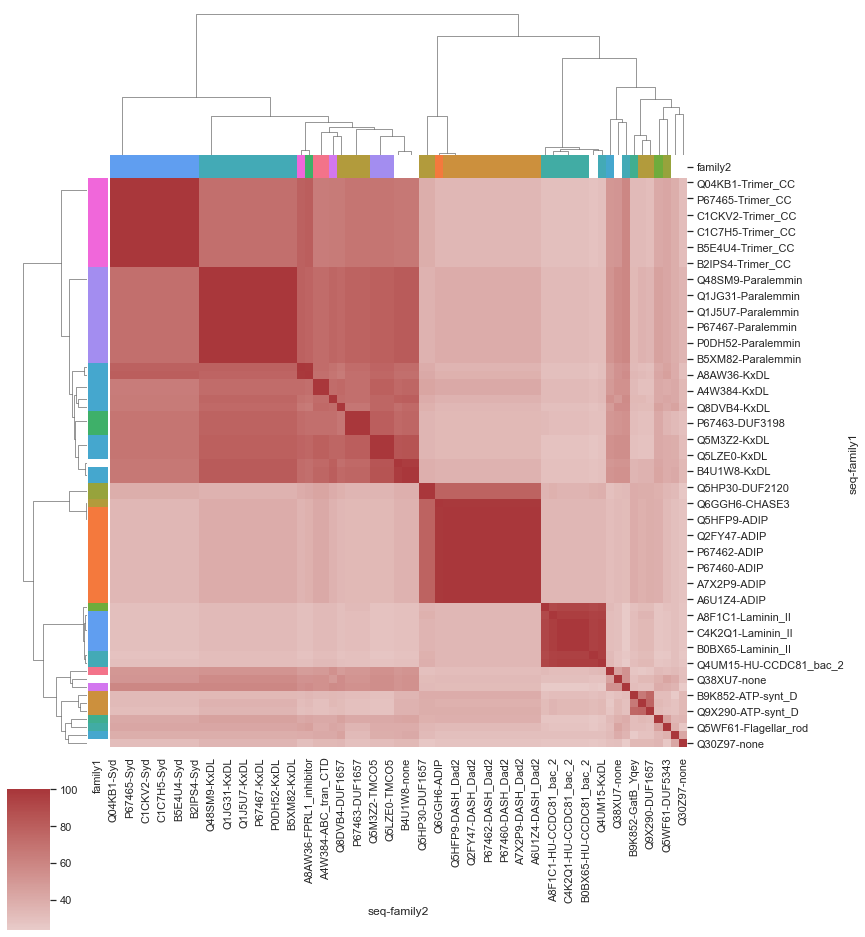

In [ ]:
cluster_plot(cluster_matrix("./../out/uniprot_sprot.40.multi-step/$$$/A0L6H5.out", 1,2), 0)

- Cluster matrix: each sequence compared to every other sequence in the cluster
- Left-most column: each color represents PFAM domain that got the best score for the sequence
- Top row: each color represents PFAM domain that got the second best score for the sequence
- Clear patterns between different PFAM domains
- White family color -> no PFAM domain fit the treshhold for that sequence

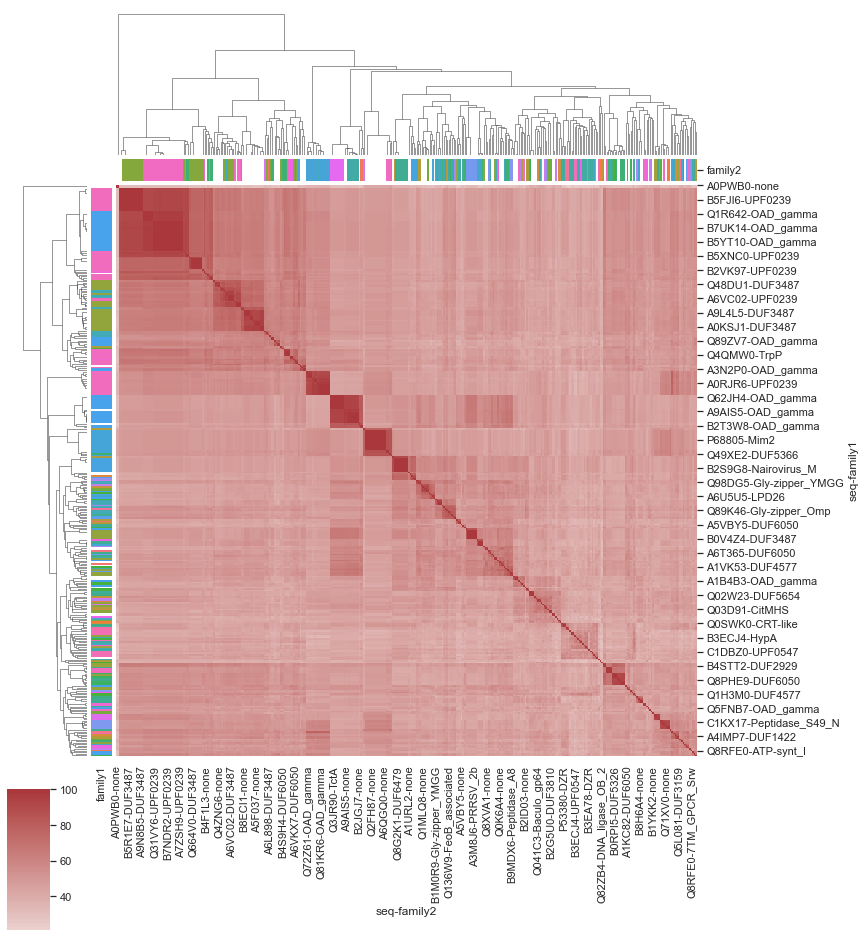

In [ ]:
cluster_plot(id_matrix)

- Same, but for a much bigger cluster

In [ ]:
ms40 = load_all("./../out/uniprot_sprot.40.multi-step/$$$/*.out", lim=10000, normalise=False)
ms70 = load_all("./../out/uniprot_sprot.70.multi-step/$$$/*.out", lim=10000, normalise=False)
ms90 = load_all("./../out/uniprot_sprot.90.multi-step/$$$/*.out", lim=10000, normalise=False)

In [ ]:
def group_info(df, s):
    print("--------")
    print(s)
    temp = df.reset_index().drop_duplicates(subset=["index"], keep="first").set_index("index")
    shape = temp.drop_duplicates(subset=["reference"]).shape
    f = temp.groupby(["reference", "family"]).size().reset_index().groupby("reference").count().mean().values[0]
    b_count = sum(temp["str"].str.count("B") > 0)
    z_count = sum(temp["str"].str.count("Z") > 0)
    x_count = sum(temp["str"].str.count("X") > 0)
    print(f"Number of clusters: {shape[0]}")
    print(f"Avg. cluster size: %.2f" % temp.groupby("reference").count().mean().values[0])
    print(f"Domains per cluster: %.2f" % f)
    print("Average identity: %.1f" % temp["identity"].mean())
    print("Min identity: %.1f" % temp["identity"].min())
    print("Max identity: %.1f" % temp["identity"].max())
    print("Longest sequence: %d" % df["seqlen"].max())
    print("Special amino acid \"B\" found in %d sequences (%.3f%%)" % (b_count, b_count * 100.0 / temp.shape[0]))
    print("Special amino acid \"Z\" found in %d sequences (%.3f%%)" % (z_count, z_count * 100.0 / temp.shape[0]))
    print("Special amino acid \"X\" found in %d sequences (%.3f%%)" % (x_count, z_count * 100.0 / temp.shape[0]))
    print("--------")


In [ ]:
group_info(ms40, "Multi-step, 40%")
group_info(ms70, "Multi-step, 70%")
group_info(ms90, "Multi-step, 90%")

--------
Multi-step, 40%
Number of clusters: 1519
Avg. cluster size: 188.59
Domains per cluster: 1.17
Average identity: 53.0
Min identity: 15.0
Max identity: 100.0
Longest sequence: 3434
Special amino acid "B" found in 60 (0.021%) sequences
Special amino acid "Z" found in 52 (0.018%) sequences
--------
--------
Multi-step, 70%
Number of clusters: 960
Avg. cluster size: 96.94
Domains per cluster: 1.05
Average identity: 79.6
Min identity: 46.0
Max identity: 100.0
Longest sequence: 2321
Special amino acid "B" found in 17 (0.018%) sequences
Special amino acid "Z" found in 16 (0.017%) sequences
--------
--------
Multi-step, 90%
Number of clusters: 232
Avg. cluster size: 75.91
Domains per cluster: 1.03
Average identity: 93.9
Min identity: 77.2
Max identity: 100.0
Longest sequence: 1342
Special amino acid "B" found in 1 (0.006%) sequences
Special amino acid "Z" found in 1 (0.006%) sequences
--------


In [ ]:
mcl70 = load_all("./../out/uniprot_sprot.70.mcl/$$$/*.out", lim=10000, normalise=False)
mcl90 = load_all("./../out/uniprot_sprot.90.mcl/$$$/*.out", lim=10000, normalise=False)

In [ ]:
group_info(mcl70, "MCL, 70%")
group_info(mcl90, "MCL, 90%")

--------
MCL, 70%
Number of clusters: 189
Avg. cluster size: 60.03
Domains per cluster: 1.04
Average identity: 83.0
Min identity: 44.8
Max identity: 100.0
Longest sequence: 1056
Special amino acid "B" found in 0 (0.000%) sequences
Special amino acid "Z" found in 0 (0.000%) sequences
--------
--------
MCL, 90%
Number of clusters: 23
Avg. cluster size: 58.91
Domains per cluster: 1.09
Average identity: 91.1
Min identity: 40.0
Max identity: 100.0
Longest sequence: 529
Special amino acid "B" found in 0 (0.000%) sequences
Special amino acid "Z" found in 0 (0.000%) sequences
--------
